In [1]:
from dap_aria_mapping.getters.docs_with_topics import openalex_with_coocc_topics, patents_with_coocc_topics
from dap_aria_mapping.getters.taxonomies import get_cooccurrence_taxonomy
from dap_aria_mapping.getters.patents import get_patents
from dap_aria_mapping.getters.openalex import get_openalex_institutes, get_openalex_authorships
from dap_aria_mapping.utils.aggregation import topic_distributions, taxonomy_distribution, topics_per_institution_distribution
import operator
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
import random
from nesta_ds_utils.viz.altair import formatting, saving
import altair as alt
formatting.setup_theme()


In [3]:
oa = openalex_with_coocc_topics(level = 1)

In [2]:
patents = patents_with_coocc_topics(level = 1)

In [5]:
def topic_distributions(docs):
    absolute_dist = defaultdict(int)
    for doc, topics in docs.items():
        for topic in set(topics):
            absolute_dist[topic] += 1
    proportional_dist = defaultdict(float)
    for key, val in absolute_dist.items():
        proportional_dist[key] = val/len(docs)
        
    return absolute_dist, proportional_dist

In [250]:
def institution_distributions(docs, institutions, total_institutions):
    absolute_dist = defaultdict(lambda: defaultdict(int))
    for doc, topics in docs.items():
        inst_list = institutions[doc]
        for institution in inst_list:
            for topic in set(topics):
                absolute_dist[topic][institution] += 1
    proportional_dist = defaultdict(lambda: defaultdict(int))
    for topic, institution_dict in absolute_dist.items():
        for inst, count in institution_dict.items():
            proportional_dist[topic][inst] = count/total_institutions
        
    return absolute_dist, proportional_dist

In [247]:
def format_patent_institutions(patentdf):
    all_institutions = []
    institution_dict = defaultdict(list)
    for i, row in patentdf.iterrows():
        institutions = row['assignee_harmonized_names']
        for inst in institutions:
            institution_dict[row['publication_number']].append(inst)
            all_institutions.append(inst)
    return institution_dict, len(set(all_institutions))

In [396]:
def format_oa_institutions(authorshipDf, institutions_lookup):
    all_institutions = []
    institution_dict = defaultdict(list)
    for i, row in authorshipDf.iterrows():
        work = row['id']
        instId = row['inst_id']
        try:
            name = institutions_lookup[instId]
        except KeyError:
            name = instId
            continue
        institution_dict[work].append(name)
        all_institutions.append(name)
    return institution_dict, len(set(all_institutions))

In [6]:
def taxonomy_distribution(taxLevel):
    dist = defaultdict(float)
    for taxid, count in pd.DataFrame(taxLevel.value_counts()).iterrows():
        dist[taxid] = count[0]/len(taxLevel)
    return dist

In [7]:
oa_abs_dist, oa_proportion_dist = topic_distributions(oa)

In [3]:
patent_abs_dist, patent_proportion_dist = topic_distributions(patents)

In [4]:
tax = get_cooccurrence_taxonomy()

### Distribution of Taxonomy at Level 1

This plot shows the percent of entities in the entire corpus allocated to each topic. The distribution is clearly quite skewed, so this needs to be considered when evaluating the proportion of documents on certain topics.

<BarContainer object of 25 artists>

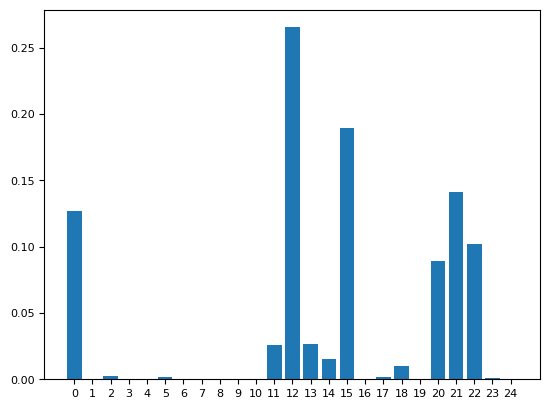

In [5]:
level1tax = tax['Level_1']
tax_dist = taxonomy_distribution(level1tax)
plt.bar([int(key) for key in tax_dist.keys()], tax_dist.values(),tick_label = [int(key) for key in tax_dist.keys()] )

# Proportion of Topics 

## OpenAlex

In [17]:
level1_topics = pd.DataFrame.from_dict(oa_proportion_dist, orient='index').join(pd.DataFrame.from_dict(patent_proportion_dist, orient='index'),lsuffix='_publications', rsuffix='_patents').unstack().reset_index().rename(columns = {"level_0":"pat/pub","level_1":"topic",0:"percent"}) 
print(level1_topics.head())
#plt.bar([int(key) for key in oa_proportion_dist.keys()], oa_proportion_dist.values(),tick_label = [int(key) for key in oa_proportion_dist.keys()] )

          pat/pub topic   percent
0  0_publications     0  0.213590
1  0_publications    22  0.110441
2  0_publications    11  0.036024
3  0_publications    12  0.380441
4  0_publications    20  0.109405


In [115]:
sort_order = level1_topics.groupby(level1_topics['topic'])['percent'].sum().sort_values(ascending=False)

In [116]:
figure = alt.Chart(level1_topics).mark_bar(
    opacity=1,
    ).encode(
    column = alt.Column('topic:N', spacing = 3, header = alt.Header(labelOrient = "top"), sort = list(sort_order.keys())),
    x =alt.X('pat/pub:N', axis=None),
    y =alt.Y('percent:Q'),
    color= alt.Color('pat/pub:N')
).configure_view(stroke='transparent')
#figure.show()
saving.save(figure, name='level1_misalignment', path='outputs/figures')

/Users/emilybicks/opt/anaconda3/envs/dap_aria_mapping/lib/python3.8/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


## Patents 

<BarContainer object of 19 artists>

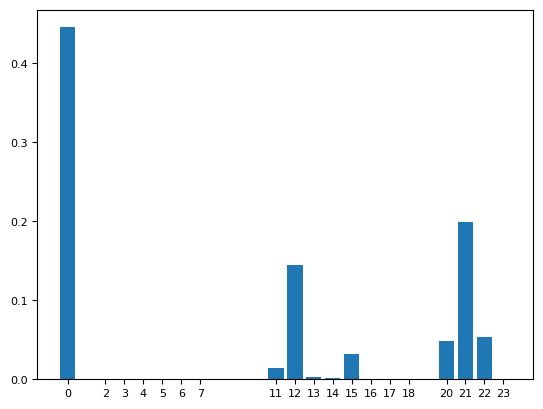

In [7]:
plt.bar([int(key) for key in patent_proportion_dist.keys()], patent_proportion_dist.values(),tick_label = [int(key) for key in patent_proportion_dist.keys()] )

## Highlighted Findings 

Topic 0 appears to be more represented in Patents vs. Publications - Over 40% of documents in Patents are about topic 0, whereas only about 20% of Publications are on Topic 0. A random sample of 50 entities from Topic 0 shows that it is likely about Chemical Engineering. 

In [57]:
print(random.sample(list(tax[tax['Level_1']=='0'].index),10))

['Spycatcher', 'Deep-level transient spectroscopy', 'Kesterite', 'European emission standards', 'Phenethylamine', 'Microstrip', 'Otto cycle', 'Bis-GMA', 'Industrial Emissions Directive', 'Dislocation']


In [58]:
print(random.sample(list(tax[tax['Level_1']=='12'].index),10))

['Betaretrovirus', 'Systemic lupus erythematosus', 'Gingival sulcus', 'Angioscopy', 'Human variability', 'Protein 4.2', 'Mental health trust', 'Lymphokine', 'Sesamoid bone', 'Triazolam']


Topic 15 appears to be more represented in Publications vs. Patents - About 20% of documents in Publications are about topic 15, whereas only about 5% of Patents are on Topic 15. A random sample of 50 entities from Topic 15 shows that it is likely related to Sociology.

In [63]:
print(random.sample(list(tax[tax['Level_1']=='15'].index),10))

['Financial Services Authority', 'Autonomous communities of Spain', 'Cello', 'Quasi-market', 'Feminist Media Studies', 'Peter Galton', 'Terroir', 'Faith school (United Kingdom)', 'Classical Athens', 'Syllable']


# Focus on Composition of Topic 21 - Computer Science / Mathematics

In [20]:
print(random.sample(list(tax[tax['Level_1']=='21'].index),50))

['Price discovery', 'Command and control', 'Filter bank', 'Classifying space', 'NL-complete', 'Grid computing', 'Congruence subgroup', 'Graceful exit', 'Temporal discretization', 'Unit vector', 'Functional data analysis', 'Black hole', 'Combinatorial design', 'Deviance information criterion', 'Data compression', 'Non-Euclidean geometry', 'Polygon mesh', 'Hankel transform', 'Community informatics', 'Creative accounting', 'Stochastic dominance', 'Principal curvature', 'Algebraic structure', 'Data aggregation', 'Bring your own device', 'Baker Botts', 'Hugh Everett III', 'Spectral geometry', 'Associative algebra', 'Deep belief network', 'Hilbert scheme', 'Microsoft Office', 'Belief propagation', 'Cognitive computing', 'Hecke algebra of a locally compact group', 'Portlet', 'Seesaw', 'Hans Zassenhaus', 'Treebank', 'Femtocell', 'RISC-V', 'Payment Card Industry Data Security Standard', 'Codimension', 'Birds in music', 'Free boundary condition', 'FK Rad', 'Convex polytope', 'Coiflet', 'Computat

In [21]:
print(tax.filter(items = ['Computer science'], axis=0))
print(tax.filter(items = ['Artificial intelligence'], axis=0))
print(tax.filter(items = ['Machine learning'], axis=0))

                 Level_1 Level_2   Level_3      Level_4      Level_5
Entity                                                              
Computer science      21   21_25  21_25_27  21_25_27_14  21_25_27_14
                        Level_1 Level_2  Level_3    Level_4    Level_5
Entity                                                                
Artificial intelligence      21   21_52  21_52_2  21_52_2_2  21_52_2_2
                 Level_1 Level_2 Level_3   Level_4   Level_5
Entity                                                      
Machine learning      21    21_7  21_7_5  21_7_5_8  21_7_5_8


## Level 2

In [13]:
oa2 = openalex_with_coocc_topics(level = 2)

In [10]:
patents2 = patents_with_coocc_topics(level = 2)

In [14]:
oa2absdist, oa2dist = topic_distributions(oa2)
oa2dist21 = {k: v for k, v in oa2dist.items() if k[:3] == '21_'}

In [15]:
pa, patents2dist = topic_distributions(patents2)
patents2dist21 = {k: v for k, v in patents2dist.items() if k[:3] == '21_'}

In [16]:
level2_21topics = pd.DataFrame.from_dict(oa2dist21, orient='index').join(pd.DataFrame.from_dict(patents2dist21, orient='index'),lsuffix='_publications', rsuffix='_patents').unstack().reset_index().rename(columns = {"level_0":"pat/pub","level_1":"topic",0:"percent"}) 
level2_21topics[['level_1_topic', 'level_2_topic']] = level2_21topics["topic"].apply(lambda x: pd.Series(str(x).split("_")))
sort_order2 = list(level2_21topics.groupby(level2_21topics['level_2_topic'])['percent'].sum().sort_values(ascending=False).keys())

In [17]:
figure2 = alt.Chart(level2_21topics).mark_bar(
    opacity=1,
    ).encode(
    column = alt.Column('level_2_topic:N', spacing = 3, header = alt.Header(labelOrient = "top", labelFontSize=14), sort=sort_order2),
    x =alt.X('pat/pub:N', axis = None),
    y =alt.Y('percent:Q', axis = alt.Axis(labels = True)),
    color= alt.Color('pat/pub:N')
).configure_view(stroke='transparent').properties(
    width=15)
figure2.show()
saving.save(figure2, name='level2_misalignment', path='outputs/figures')

/Users/emilybicks/opt/anaconda3/envs/dap_aria_mapping/lib/python3.8/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


Displaying chart at http://localhost:56335/


[WDM] - Downloading: 100%|██████████████████| 8.72M/8.72M [00:10<00:00, 833kB/s]
/Users/emilybicks/opt/anaconda3/envs/dap_aria_mapping/lib/python3.8/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


## Interesting Findings 

At the higest level, both Patents and Publications appear to be about Topic 21 approx 20% of the time. Topic 21 appears to contain content related to Computer Science/Mathematics. What is interesting is the breakdown of that topic within Patents and Publictations.

Sub-topic 24 is the 3rd most represented topic within 21 in patents, with about 2.5% of all patents being about that sub-topic. However <1% of all publications are on that subtopic. A random sample of the entities within that subtopic shows that it appears to be about cybersecurity.

Sub-topic 39 shows a similar pattern. It is in over 3% of all patents, but about 1% of publications. Sub-topic 39 appears to be about scaled computing architectures.

In [197]:
print(random.sample(list(tax[tax['Level_2']=='21_24'].index),5))

['Binary file', 'Password policy', 'Transport Layer Security', 'EMV', 'International Federation for Information Processing']


In [194]:
print(random.sample(list(tax[tax['Level_2']=='21_39'].index),5))

['Symbolic simulation', 'Heterogeneous computing', 'Computer memory', 'Functional verification', 'Basic block']


On the other hand, sub-topic 17 is much more represented in publications (nearly 3% of all publications), but much less in patents (<1% of all patents). Sub-topic 17 appears to be about Physics.

Similarly, sub-topic 3 is much more represented in publications (>3% of all pubs) but only about 1% of patents. Sub-topic 3 appears to be about finance/economics.

In [200]:
print(random.sample(list(tax[tax['Level_2']=='21_17'].index),5))

['M-theory', 'Comoving and proper distances', 'T2K experiment', 'Big Crunch', 'SO(10) (physics)']


In [196]:
print(random.sample(list(tax[tax['Level_2']=='21_3'].index),5))

['Public bad', 'Consumption tax', 'Nord Pool AS', 'Economic bubble', 'Relative valuation']


## Level 3 

Subtopic 44 is the most prevalent subtopic within 21 for both Publications and Patents, which generally appears to be about networking, but contains other algorithmic terms as well.

In [67]:
print(random.sample(list(tax[tax['Level_2']=='21_44'].index),50))

['Cross-layer optimization', 'Molecular communication', 'Ethernet', 'Signal processing', 'OPNET', 'Service Access Point', 'Connected car', 'Optical communication', 'Repetition code', 'Software-defined radio', 'Adaptive coding', 'Base station', 'Spatial multiplexing', 'End-to-end delay', 'Telnet', 'Mesh networking', 'Viterbi algorithm', 'Convex optimization', 'Small cell', 'Network interface device', 'Location identifier', 'IEEE 802.16', 'Routing table', 'Network planning and design', 'Finite impulse response', 'Time to live', 'Fully qualified domain name', 'Value-added service', 'Bandwidth management', 'GERAN', 'Spectral density', 'Speech synthesis', 'Probabilistic neural network', 'Radio propagation', 'Operations support system', 'IPv4', 'Defragmentation', 'Dynamic Adaptive Streaming over HTTP', 'IEEE 802.11', 'Edge computing', 'Picocell', 'Mobile edge computing', 'Compressed sensing', 'Diversity scheme', 'Error detection and correction', 'Superframe', 'Adaptive switching', 'Synchrono

In [39]:
oa3 = openalex_with_coocc_topics(level = 3)
patents3 = patents_with_coocc_topics(level = 3)

### OpenAlex 

In [43]:
blah, oa3dist = topic_distributions(oa3)
oa3dist21_44 = {k: v for k, v in oa3dist.items() if k[:5] == '21_44'}

<BarContainer object of 45 artists>

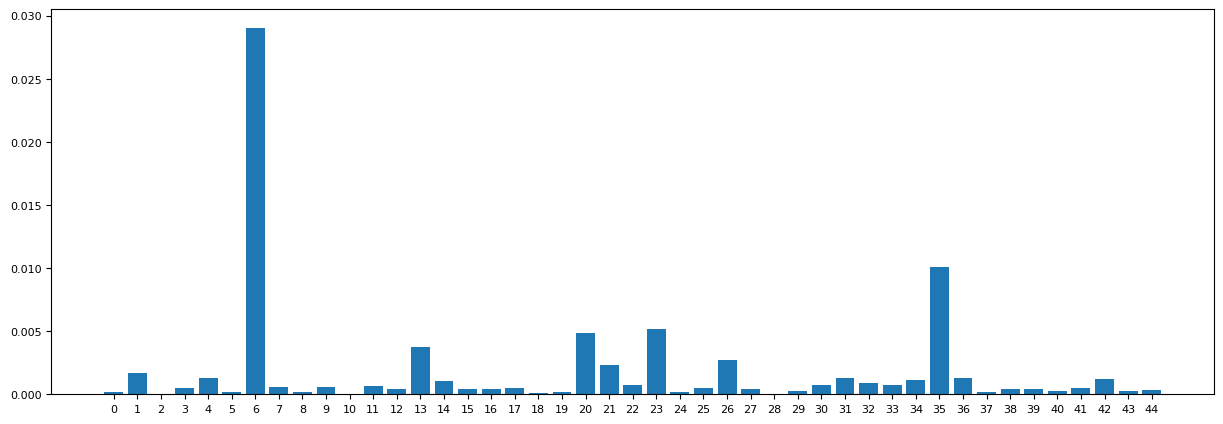

In [47]:
plt.rcParams["figure.figsize"] = (15,5)
plt.bar([int(key.split("_")[2]) for key in oa3dist21_44.keys()], oa3dist21_44.values(), tick_label = [int(key.split("_")[2]) for key in oa3dist21_44.keys()])

### Patents 

In [48]:
blah, patents3dist = topic_distributions(patents3)
patents3dist21_44 = {k: v for k, v in patents3dist.items() if k[:5] == '21_44'}

<BarContainer object of 45 artists>

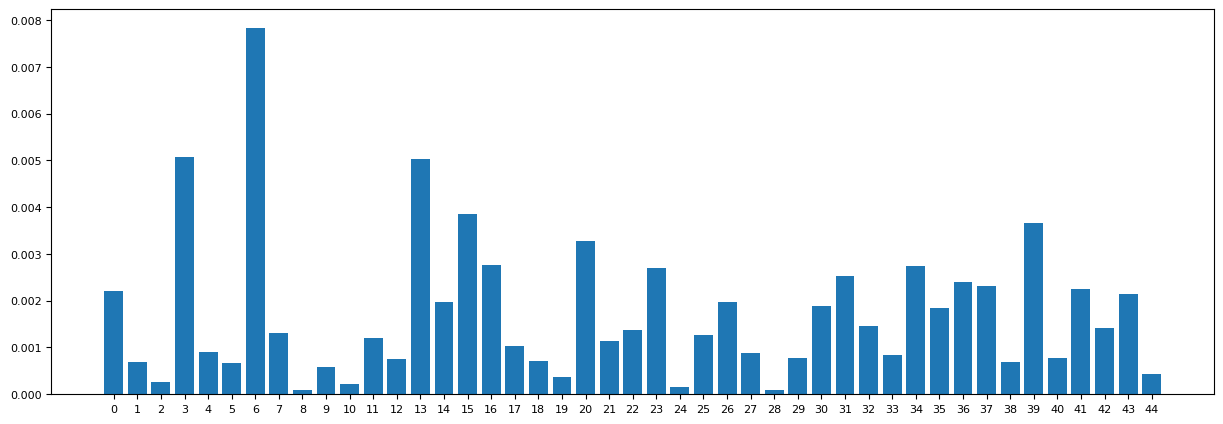

In [49]:
plt.bar([int(key.split("_")[2]) for key in patents3dist21_44.keys()], patents3dist21_44.values(), tick_label = [int(key.split("_")[2]) for key in patents3dist21_44.keys()])

In [406]:
print(list(tax[tax['Level_3']=='21_3_1'].index))

['Particle system', 'Extreme value theory', 'Actuarial science', 'Shared transport', 'Optimal stopping', 'Stay Positive (album)', 'Option (finance)', 'Entrance Point', 'Moving-average model', 'Queueing theory', 'Carsharing', 'Hypergeometric function', 'Markov chain', 'Esscher transform', 'Applied probability', 'Interacting particle system', 'Likelihood function', 'Lévy process']


In [407]:
print(list(tax[tax['Level_3']=='21_3_2'].index))

['Securities lending', 'Initial public offering', 'Global saving glut', 'China Securities Regulatory Commission', 'Disintermediation', 'Macro risk', 'Economic bubble', 'Alibaba Group', 'Baidu', 'Specialty registrar', 'Shanghai Stock Exchange', 'Tencent', 'Pierre-Simon Laplace', 'Volatile Times', 'Irish National Liberation Army', 'Shenzhen Stock Exchange', 'Procyclical and countercyclical', '49 Percent', 'Market liquidity', 'Hoarding', 'Hong Kong Stock Exchange', 'Taobao', 'Positive behavior support', 'Margin (finance)', 'Size premium', 'Fire sale', 'Capital adequacy ratio']


In [409]:
print(list(tax[tax['Level_3']=='21_17_1'].index))

['Pomeron', 'DGLAP', 'Sherpa people', 'Fragmentation function', 'QCD matter', 'Quantum chromodynamics', 'Regge theory', 'Factorial', 'CLAS detector', 'W and Z bosons', 'Quantum statistical mechanics', 'Renormalization', 'Deep inelastic scattering', 'Event generator', 'Electromagnetism', 'Oscillon', 'Black Hat Briefings', 'Drell–Yan process', 'Vacuum polarization', 'STAR detector', 'Hadronization', 'Scattering amplitude', 'James Bjorken', 'Center-of-momentum frame', 'Soft-collinear effective theory', 'Coupling constant', 'HERMES experiment', 'Optical theorem', 'Sigma', 'Perturbation theory', 'Gluon', 'Hyperon', 'Branch point', 'Sine-Gordon equation', 'PYTHIA', 'Elementary particle', 'Four-momentum', 'Relativistic Heavy Ion Collider', 'Vector boson', 'Weinberg angle', 'Thomas Jefferson National Accelerator Facility', 'Zimbabwean dollar', 'Parton (particle physics)']


In [415]:
print(list(tax[tax['Level_3']=='21_17_7'].index))

['Analytic continuation', 'Big Bang', 'Static universe', 'Conformal map', 'Big Crunch', 'Big Rip', 'Holographic principle', 'Gravitational singularity']


### Interesting Findings 

The distribution of sub-sub-topics within sub-topic 44 is much more skewed for publications. Publications within this sub-stopic, are predominantly about sub-sub topic 6, which is about algorithmic optimisation. 

In [65]:
print(list(tax[tax['Level_3']=='21_44_6'].index))

['Unmanned aerial vehicle', 'Multiple edges', 'Guangzhou Bus Rapid Transit', 'MSISDN', 'Fractional programming', 'Mobile edge computing', 'Supply chain optimization', 'Proximal gradient methods for learning', 'Hadamard matrix', 'Extremely high frequency', 'Convex optimization', 'Coordinate descent', 'Nonnegative matrix', 'Mathematical optimization', 'Demand load', 'Stochastic optimization', 'Ky Fan', 'Duality (optimization)', 'Edge computing', 'Segment routing', 'Value-added service', 'Lyapunov optimization', 'Microsoft Edge', 'Content delivery network', 'Algorithm']


There are a significant number of patents in may other sub-sub topics within sub-topic 44, such as 3 and 39 which both appear to be about telecommunications. 

In [71]:
print(list(tax[tax['Level_3']=='21_44_3'].index))
print(list(tax[tax['Level_3']=='21_44_39'].index))

['E-UTRA', 'Media gateway', 'Packet radio', 'Mobile radio', 'Radio access network', 'UMTS Terrestrial Radio Access Network', 'Information system', 'Network switching subsystem', 'Source Radio', 'Mobile phone', 'System Architecture Evolution', 'Legacy system', 'Circuit switching', 'Voice call continuity', 'New York Call', 'GSM', 'General Packet Radio Service', 'GPRS core network', 'GERAN', 'High Speed Packet Access', 'UMTS (telecommunication)', 'Access stratum', 'Radio Network Controller', 'Telecommunications network']
['Multimedia Broadcast Multicast Service', 'Single-frequency network', 'Push-to-talk', '3GPP', 'LTE (telecommunication)', 'Communications system']


## Institutions within topic 21

In [259]:
patent_full_data = get_patents()

In [263]:
patent_institutions, total_institutions = format_patent_institutions(patent_full_data)

In [266]:
print(patent_institutions['WO-2010094455-A1'])

['MERCK PATENT GMBH', 'LIETZAU LARS', 'FARRAND LOUISE DIANE', 'CZANTA MARKUS', 'HIRSCHMANN HARALD', 'WITTEK MICHAEL', 'SAITO IZUMI', 'SCHULER BRIGITTE']


In [268]:
total_institutions

136629

In [276]:
patentsdistinstitutions_absolute, patentsdistinstitutions_prop = institution_distributions(patents,patent_institutions, total_institutions)

In [273]:
print(list(blah.keys())[:10])

['12', '0', '21', '22', '20', '11', '15', '14', '18', '13']


In [295]:
sorted_21 =  dict(sorted(patentsdistinstitutions_absolute['21'].items(), key=operator.itemgetter(1),reverse=True))
top_institutions = list(sorted_21.keys())[:20]
top_institutions_df = pd.DataFrame.from_dict({inst: sorted_21[inst] for inst in top_institutions},orient = 'index').reset_index().rename(columns = {'index':'institution', 0:'doc_count'})

                           institution  doc_count
0                                  IBM       2253
1                     BRITISH TELECOMM       1024
2               ADVANCED RISC MACH LTD        941
3           SAMSUNG ELECTRONICS CO LTD        619
4                      ROLLS ROYCE PLC        567
5                            SONY CORP        497
6                               NXP BV        478
7                 IMAGINATION TECH LTD        474
8                JAGUAR LAND ROVER LTD        440
9                         QUALCOMM INC        437
10                      ALCATEL LUCENT        435
11                     BAE SYSTEMS PLC        400
12                      MICROSOFT CORP        400
13  MICROSOFT TECHNOLOGY LICENSING LLC        392
14      HEWLETT PACKARD DEVELOPMENT CO        366
15                          INTEL CORP        343
16                         FUJITSU LTD        284
17                     SONY EUROPE LTD        281
18                      CISCO TECH INC        274


In [340]:
figure3 = alt.Chart(top_institutions_df).mark_bar(
    opacity=1,
    ).encode(
    x =alt.X('institution:N', axis = alt.Axis(labelFontSize = 9, labelAngle = 45), sort = top_institutions),
    y =alt.Y('doc_count:Q'),
    color=alt.value('#0000FF')
).configure_view(stroke='transparent').properties(
    height=300)
saving.save(figure3, name='topic21_patentinstitutions', path='outputs/figures')

/Users/emilybicks/opt/anaconda3/envs/dap_aria_mapping/lib/python3.8/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


In [324]:
oa_institution_list = list(oa_institutions['affiliation_string'])

In [351]:
import json
with open('institutions.json', 'r+') as f:
    oa_institutions = json.load(f)

In [357]:
oa_authorships = get_openalex_authorships()

In [360]:
oa_authorships_deduped = oa_authorships[['id','inst_id']].drop_duplicates(subset = ['id','inst_id'])

In [361]:
print(oa_authorships_deduped.head())

                                  id                           inst_id
0   https://openalex.org/W2014935324    https://openalex.org/I28407311
2   https://openalex.org/W2137015675   https://openalex.org/I100930933
3   https://openalex.org/W2137015675  https://openalex.org/I1303153112
15  https://openalex.org/W2161633633   https://openalex.org/I107606265
16  https://openalex.org/W2161633633  https://openalex.org/I4210087915


In [355]:
oa_institutions_df = pd.DataFrame.from_dict(oa_institutions)

                                 id                        ror  \
0  https://openalex.org/I4210133834  https://ror.org/03d7x2a93   
1  https://openalex.org/I4210086511  https://ror.org/003h15w42   
2  https://openalex.org/I4210134005  https://ror.org/034x48g49   
3  https://openalex.org/I4210086677  https://ror.org/00y27w112   
4  https://openalex.org/I4210134204  https://ror.org/033wj0h62   

                               display_name country_code        type  \
0                             Tritech Group           GB     company   
1               Galaxy Advanced Engineering           US     company   
2                                   Perrigo           IL     company   
3  Children’s Leukemia Research Association           US   nonprofit   
4                                  DS Smith           GB  healthcare   

                        homepage_url  \
0    https://www.tritechgroup.co.uk/   
1             http://www.gaeinc.com/   
2   http://dev.perrigo-pharma.co.il/   
3  http://

In [392]:
oa_institutions_lookup = oa_institutions_df.set_index('id').to_dict()['display_name']

In [393]:
print(list(oa_institutions_lookup.keys())[:5])

['https://openalex.org/I4210133834', 'https://openalex.org/I4210086511', 'https://openalex.org/I4210134005', 'https://openalex.org/I4210086677', 'https://openalex.org/I4210134204']


In [397]:
oa_institutions_formatted, total_oa_institutions = format_oa_institutions(oa_authorships_deduped, oa_institutions_lookup)

In [398]:
oadistinstitutions_absolute, oadistinstitutions_prop = institution_distributions(oa ,oa_institutions_formatted, total_oa_institutions)

In [399]:
sorted_21_oa =  dict(sorted(oadistinstitutions_absolute['21'].items(), key=operator.itemgetter(1),reverse=True))
top_institutions_oa = list(sorted_21_oa.keys())[:20]
top_institutions_df_oa = pd.DataFrame.from_dict({inst: sorted_21_oa[inst] for inst in top_institutions_oa},orient = 'index').reset_index().rename(columns = {'index':'institution', 0:'doc_count'})

In [404]:
figure4 = alt.Chart(top_institutions_df_oa).mark_bar(
    opacity=1,
    ).encode(
    x =alt.X('institution:N', axis = alt.Axis(labelFontSize = 12, labelAngle = 45), sort = top_institutions),
    y =alt.Y('doc_count:Q', axis = alt.Axis(orient = 'right')),
    color=alt.value('#FDB633')
).configure_view(stroke='transparent').properties(
    height=300)
#figure4.show()
saving.save(figure4, name='topic21_oainstitutions', path='outputs/figures')

In [341]:
print(oa_institutions.head())

                                 id                           auth_id  \
0  https://openalex.org/W2014935324  https://openalex.org/A2077177608   
1  https://openalex.org/W2014935324  https://openalex.org/A2017532309   
2  https://openalex.org/W2137015675  https://openalex.org/A2687388036   
3  https://openalex.org/W2137015675  https://openalex.org/A1932590790   
4  https://openalex.org/W2137015675  https://openalex.org/A2232649233   

     auth_display_name                             auth_orcid  \
0        Andre K. Geim  https://orcid.org/0000-0003-2861-8331   
1  Kostya S. Novoselov  https://orcid.org/0000-0003-4972-5371   
2       Mark A. Larkin                                   None   
3  Gordon Blackshields  https://orcid.org/0000-0003-2114-9958   
4       Nigel P. Brown                                   None   

                                  affiliation_string  \
0  Manchester Centre for Mesoscience and Nanotech...   
1  Manchester Centre for Mesoscience and Nanotech...   
2 